In [1]:
#載入套件
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
#資料讀入 
def read_file(file):
    file_path=file
    df = pd.read_csv(file_path)
    #刪除header skiprows=2
    df = pd.read_csv(file_path, header=None,skiprows=2)
    #設定欄位
    df.columns = ['date','volume','volprice','open','high','low','close','spread','num']
    df['date'] = pd.to_datetime(df['date'])
    df.set_index(('date'),inplace=True)
    return df

#讀取三年份的台積電股價csv檔案
frames=[]
for y in range(2015,2019):
    for i in range(1,13):
        i="{0:0=2d}".format(i)
        y=str(y)
        path='./'+y+'-'+i+'.csv'
        frames.append(read_file(path))

#縱向合併
df = pd.concat(frames,axis=0,ignore_index=True)

#先取出收盤價欄位
df_close=df['close']

#刪除以下兩個欄位
df = df.drop(['spread'], axis=1)
df = df.drop(['close'], axis=1)

#加入收盤價欄位在最後面
df['close']=df_close

#印出看看
df.head()

,volume,volprice,open,high,low,num,close
0,32214177,4459516134,140.5,140.5,137.5,9377,139.5
1,67649997,9104346055,137.5,137.5,133.0,26240,133.5
2,43886007,5887797145,133.5,135.0,133.5,14735,134.0
3,42551468,5839710584,136.5,138.0,136.0,12327,138.0
4,61920268,8308394250,135.0,135.5,133.0,24470,134.0


In [3]:
#正規化
def normalize(df):
    newdf= df.copy()
    min_max_scaler = preprocessing.MinMaxScaler()
    
    newdf['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['volprice'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    newdf['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    newdf['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    newdf['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    newdf['num'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    newdf['close'] = min_max_scaler.fit_transform(df.close.values.reshape(-1,1))
    
    return newdf

df_norm= normalize(df)

#正規化後印出來看看
df_norm.head()

,volume,volprice,open,high,low,num,close
0,0.190198,0.190198,0.150000,0.132653,0.166667,0.162252,0.162252
1,0.409886,0.409886,0.130000,0.112245,0.136667,0.122517,0.122517
2,0.262559,0.262559,0.103333,0.095238,0.140000,0.125828,0.125828
3,0.254285,0.254285,0.123333,0.115646,0.156667,0.152318,0.152318
4,0.374364,0.374364,0.113333,0.098639,0.136667,0.125828,0.125828


In [4]:
#對資料進行訓練集與測試集的切割，另外也定義每一筆資料要有多長的時間框架
def data_helper(df, time_frame):
    
    # 資料維度: 
    number_features = len(df.columns)

    # 將dataframe 轉成 numpy array
    datavalue = df.values
    print('datavalue.shape:',datavalue.shape)

    result = []
    # 若想要觀察的 time_frame 為20天, 需要多加一天做為驗證答案
    for index in range( len(datavalue) - (time_frame+1) ): # 從 datavalue 的第0個跑到倒數第 time_frame+1 個
        result.append(datavalue[index: index + (time_frame+1) ]) # 逐筆取出 time_frame+1 個K棒數值做為一筆 instance
    
    result = np.array(result)
    print('result.shape:',result.shape)
    number_train = round(0.9 * result.shape[0]) # 取 result 的前90% instance做為訓練資料
    print('number_train:',number_train)
    
    x_train = result[:int(number_train), :-1] # 訓練資料中, 只取每一個 time_frame 中除了最後一筆的所有資料做為feature
    y_train = result[:int(number_train), -1][:,-1] # 訓練資料中, 取每一個 time_frame 中最後一筆資料的最後一個數值(收盤價)做為答案
    print('x_train.shape:',x_train.shape)
    print('y_train.shape',y_train.shape)
    
    # 測試資料
    x_test = result[int(number_train):, :-1]
    y_test = result[int(number_train):, -1][:,-1]
    print('x_test.shape:',x_test.shape)
    print('y_test.shape:',y_test.shape)
    
    # 將資料組成變好看一點
    #x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], number_features))
    #x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], number_features))
    #print('x_train.shape:',x_train.shape)
    #print('x_test.shape:',x_test.shape)

    return [x_train, y_train, x_test, y_test]

# 以n天為一區間進行股價預測
n=30
X_train, y_train, X_test, y_test = data_helper(df_norm, n)

datavalue.shape: (973, 7)
result.shape: (942, 31, 7)
number_train: 848
x_train.shape: (848, 30, 7)
y_train.shape (848,)
x_test.shape: (94, 30, 7)
y_test.shape: (94,)


In [5]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
import keras

def build_model(input_length, input_dim):
    d = 0.3
    model = Sequential()

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=True))
    model.add(Dropout(d))

    model.add(LSTM(256, input_shape=(input_length, input_dim), return_sequences=False))
    model.add(Dropout(d))

    model.add(Dense(16,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))

    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])

    return model

# n天、7維
model = build_model( n, 7 )

Using TensorFlow backend.


In [6]:
#LSTM 模型訓練
# 一個batch有128個instance，總共跑50個迭代
model.fit( X_train, y_train,batch_size=128, epochs=100, validation_split=0.1, verbose=1)


Train on 763 samples, validate on 85 samples
Epoch 1/100
763/763 [==============================] - 4s 5ms/step - loss: 0.2054 - acc: 0.0013 - val_loss: 0.2048 - val_acc: 0.0000e+00
Epoch 2/100
763/763 [==============================] - 1s 1ms/step - loss: 0.0685 - acc: 0.0026 - val_loss: 0.0743 - val_acc: 0.0000e+00
Epoch 3/100
763/763 [==============================] - 1s 942us/step - loss: 0.0599 - acc: 0.0013 - val_loss: 0.1550 - val_acc: 0.0000e+00
Epoch 4/100
763/763 [==============================] - 1s 888us/step - loss: 0.0552 - acc: 0.0013 - val_loss: 0.0755 - val_acc: 0.0000e+00
Epoch 5/100
763/763 [==============================] - 1s 895us/step - loss: 0.0376 - acc: 0.0026 - val_loss: 0.0177 - val_acc: 0.0000e+00
Epoch 6/100
763/763 [==============================] - 1s 901us/step - loss: 0.0173 - acc: 0.0026 - val_loss: 0.0051 - val_acc: 0.0000e+00
Epoch 7/100
763/763 [==============================] - 1s 933us/step - loss: 0.0126 - acc: 0.0026 - val_loss: 0.0047 - val_ac

763/763 [==============================] - 1s 926us/step - loss: 0.0014 - acc: 0.0026 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 60/100
763/763 [==============================] - 1s 913us/step - loss: 0.0015 - acc: 0.0026 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 61/100
763/763 [==============================] - 1s 941us/step - loss: 0.0013 - acc: 0.0026 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 62/100
763/763 [==============================] - 1s 935us/step - loss: 0.0015 - acc: 0.0026 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 63/100
763/763 [==============================] - 1s 964us/step - loss: 0.0015 - acc: 0.0026 - val_loss: 0.0056 - val_acc: 0.0000e+00
Epoch 64/100
763/763 [==============================] - 1s 937us/step - loss: 0.0021 - acc: 0.0026 - val_loss: 0.0020 - val_acc: 0.0000e+00
Epoch 65/100
763/763 [==============================] - 1s 989us/step - loss: 0.0018 - acc: 0.0026 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 66/100
763/763 [===========

In [7]:
#模型預測股價及還原數值
def denormalize(df, norm_value):
    original_value = df['close'].values.reshape(-1,1)
    norm_value = norm_value.reshape(-1,1)
    
    min_max_scaler = preprocessing.MinMaxScaler()
    min_max_scaler.fit_transform(original_value)
    denorm_value = min_max_scaler.inverse_transform(norm_value)
    
    return denorm_value

#X_test = np.array(X_test).reshape((1,-1))
# 用訓練好的模型對測試資料集進行預測
pred = model.predict(X_test)

# 將預測值與正確答案還原回原來的區間值
denorm_pred = denormalize(df, pred)
denorm_ytest = denormalize(df, y_test)

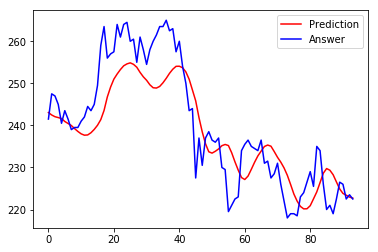

In [8]:
#預測股價結果
import matplotlib.pyplot as plt
%matplotlib inline  

plt.plot(denorm_pred,color='red', label='Prediction')
plt.plot(denorm_ytest,color='blue', label='Answer')
plt.legend(loc='best')
plt.show()